In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import cv2

In [2]:
mpl.rcParams["figure.frameon"] = False
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.labelweight"] = "normal"
mpl.rcParams["savefig.bbox"] = "tight"

sns.set_palette("colorblind")

In [3]:
BASE_PATH = Path("./data/")
PLOTS_PATH = Path("./figures/")
IMGS_PATH = BASE_PATH / "mimic-cxr-jpg-2.1.0/"
CXR24_PATH = Path("data/cxr-lt-iccv-workshop-cvamd/2.0.0/cxr-lt-2024/")
TRAIN_LABELS_FILE = CXR24_PATH / "train_labeled.csv"
print(TRAIN_LABELS_FILE)

PLOTS_PATH.mkdir(parents=True, exist_ok=True)
train_df = pd.read_csv(TRAIN_LABELS_FILE)
total_rows = len(train_df)
train_df.info()

data/cxr-lt-iccv-workshop-cvamd/2.0.0/cxr-lt-2024/train_labeled.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258871 entries, 0 to 258870
Data columns (total 46 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   dicom_id                      258871 non-null  object
 1   subject_id                    258871 non-null  int64 
 2   study_id                      258871 non-null  object
 3   ViewPosition                  248137 non-null  object
 4   ViewCodeSequence_CodeMeaning  247649 non-null  object
 5   fpath                         258871 non-null  object
 6   Adenopathy                    258871 non-null  int64 
 7   Atelectasis                   258871 non-null  int64 
 8   Azygos Lobe                   258871 non-null  int64 
 9   Calcification of the Aorta    258871 non-null  int64 
 10  Cardiomegaly                  258871 non-null  int64 
 11  Clavicle Fracture             258871 non-null  in

In [4]:
patients = train_df["subject_id"].unique()
print(f"Total number of patients: {len(patients)}")

Total number of patients: 45480


study_id
2      16672
3       5018
4       4814
1       3866
6       2422
       ...  
107        1
157        1
94         1
115        1
80         1
Name: count, Length: 108, dtype: int64


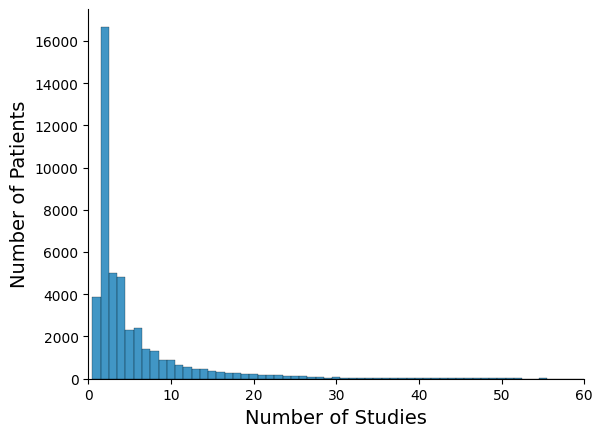

In [5]:
patient_studies = train_df.groupby("subject_id")["study_id"].count()
print(patient_studies.value_counts())

# plt.figure(figsize=(8, 10))
ax = sns.histplot(patient_studies, discrete=True)
plt.xlim(0, 60)
plt.xlabel("Number of Studies")
plt.ylabel("Number of Patients")

plt.savefig(PLOTS_PATH / "studies_per_patient.svg")
plt.show()

Total number of studies: 155823
fpath
2     71298
1     69478
3     13529
4      1422
5        67
6        24
8         2
9         1
11        1
7         1
Name: count, dtype: int64


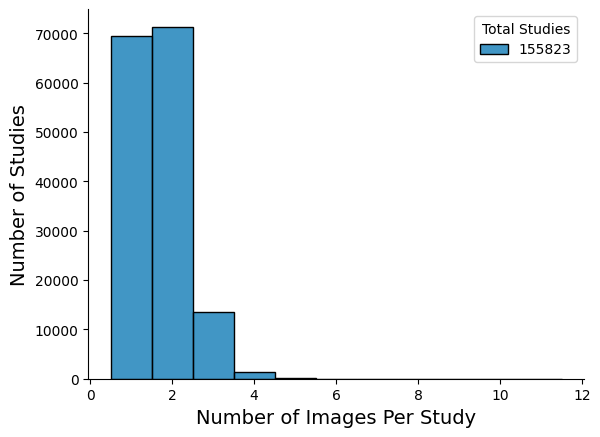

In [6]:
study_images = train_df.groupby("study_id")["fpath"].count()
print(f"Total number of studies: {len(study_images)}")
print(study_images.value_counts())

ax = sns.histplot(study_images, discrete=True)
plt.xlabel("Number of Images Per Study")
plt.ylabel("Number of Studies")
ax.legend([len(study_images)], title="Total Studies", loc="upper right")

plt.savefig(PLOTS_PATH / "study_images_histogram.svg")
plt.show()

ViewPosition
AP                100024
PA                 66470
LATERAL            57546
LL                 24080
LAO                    3
RAO                    3
PA LLD                 3
XTABLE LATERAL         2
AP AXIAL               2
AP LLD                 1
SWIMMERS               1
AP RLD                 1
PA RLD                 1
Name: count, dtype: int64
      View  Counts
0  Frontal  166508
1  Lateral   81633
2  Missing   10734


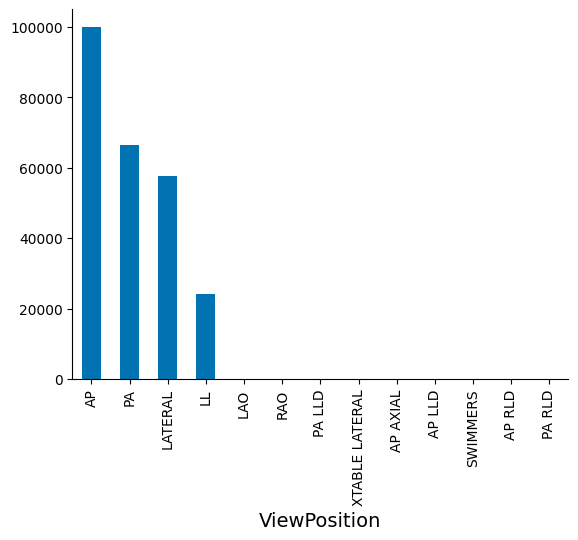

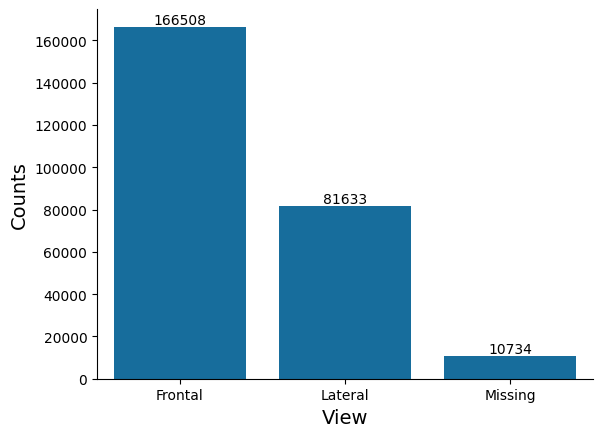

In [7]:
print(train_df["ViewPosition"].value_counts())
FRONTAL_CODES = [
    "AP",
    "PA",
    "LAO",
    "RAO",
    "AP AXIAL",
    "AP LLD",
    "PA LLD",
    "AP RLD",
    "PA RLD",
]
LATERAL_CODES = ["LATERAL", "LL", "XTABLE LATERAL", "SWIMMERS"]

view_count = pd.DataFrame(
    {
        "View": ["Frontal", "Lateral", "Missing"],
        "Counts": [
            train_df["ViewPosition"][
                train_df["ViewPosition"].str.contains("|".join(FRONTAL_CODES), na=False)
            ].count(),
            train_df["ViewPosition"][
                train_df["ViewPosition"].str.contains("|".join(LATERAL_CODES), na=False)
            ].count(),
            train_df["ViewPosition"].isna().sum(),
        ],
    }
)
print(view_count)
train_df["ViewPosition"].value_counts().plot(kind="bar")
plt.show()

# plt.figure(figsize=(5, 5))
ax = sns.barplot(
    x="View",
    y="Counts",
    data=view_count,
    errorbar=None,
)
ax.bar_label(ax.containers[0], fmt="%d")
plt.savefig(PLOTS_PATH / "cxr24_view_counts.svg")
plt.show()


## Question 1: What should I do with the images with missing view information as shown in the above plot?

Missing view information occurs in about 4% of the training images

These are the options I am considering:
- Option 1: discard them
- Option 2: manually add the view information by viewing them and determining whether they are frontal or lateral

The main reason I need to consider this is because I will eventually train different backbones to handle each view separately (Frontal and lateral), so each image must have a view label.

In [8]:
view_codes = train_df["ViewPosition"].dropna().unique()
print(f"All view codes: {view_codes}")

n_view_code_meaning_missing = train_df["ViewCodeSequence_CodeMeaning"].isna().sum()
n_view_code_missing = train_df["ViewPosition"].isna().sum()
print(f"Number of missing view codes: {n_view_code_missing}")
print(
    f"Number of view codes with missing description: {n_view_code_meaning_missing - n_view_code_missing}"
)


codes_missing_desc = (
    train_df["ViewPosition"][train_df["ViewCodeSequence_CodeMeaning"].isna()]
    .dropna()
    .unique()
)
print(f"View codes with missing description: {codes_missing_desc}")

assert len(view_codes) == len(FRONTAL_CODES) + len(LATERAL_CODES), (
    f"Incomplete view codes set: {FRONTAL_CODES + LATERAL_CODES} vs {view_codes}"
)
FRONTAL_CAT, LATERAL_CAT = "Frontal", "Lateral"
view_col = np.where(
    train_df["ViewPosition"].str.contains("|".join(FRONTAL_CODES), na=False),
    FRONTAL_CAT,
    np.where(
        train_df["ViewPosition"].str.contains("|".join(LATERAL_CODES), na=False),
        LATERAL_CAT,
        "Unknown",
    ),
)
train_df.insert(
    loc=train_df.columns.get_loc("ViewCodeSequence_CodeMeaning") + 1,
    column="View",
    value=view_col,
)
train_df.head()

All view codes: ['PA' 'LATERAL' 'AP' 'LL' 'LAO' 'RAO' 'AP AXIAL' 'SWIMMERS' 'AP LLD'
 'XTABLE LATERAL' 'PA LLD' 'AP RLD' 'PA RLD']
Number of missing view codes: 10734
Number of view codes with missing description: 488
View codes with missing description: ['AP' 'LL' 'PA' 'PA LLD' 'PA RLD']


,dicom_id,subject_id,study_id,ViewPosition,ViewCodeSequence_CodeMeaning,View,fpath,Adenopathy,Atelectasis,Azygos Lobe,...,Pneumoperitoneum,Pneumothorax,Pulmonary Embolism,Pulmonary Hypertension,Rib Fracture,Round(ed) Atelectasis,Subcutaneous Emphysema,Support Devices,Tortuous Aorta,Tuberculosis
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,s50414267,PA,postero-anterior,Frontal,files/p10/p10000032/s50414267/02aa804e-bde0afd...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,s50414267,LATERAL,lateral,Lateral,files/p10/p10000032/s50414267/174413ec-4ec4c1f...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,s53189527,PA,postero-anterior,Frontal,files/p10/p10000032/s53189527/2a2277a9-b0ded15...,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,10000032,s53189527,LATERAL,lateral,Lateral,files/p10/p10000032/s53189527/e084de3b-be89b11...,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,s53911762,AP,antero-posterior,Frontal,files/p10/p10000032/s53911762/68b5c4b1-227d048...,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [9]:
train_df[train_df["ViewPosition"].isna()]

,dicom_id,subject_id,study_id,ViewPosition,ViewCodeSequence_CodeMeaning,View,fpath,Adenopathy,Atelectasis,Azygos Lobe,...,Pneumoperitoneum,Pneumothorax,Pulmonary Embolism,Pulmonary Hypertension,Rib Fracture,Round(ed) Atelectasis,Subcutaneous Emphysema,Support Devices,Tortuous Aorta,Tuberculosis
18,8039752c-2ea661b7-16f1eafe-055b7e7b-dbd4cdd1,10001122,s53447138,NaN,NaN,Unknown,files/p10/p10001122/s53447138/8039752c-2ea661b...,0,0,0,...,0,0,0,0,0,0,0,0,0,1
19,832b57d8-3ae08663-e152699e-51c5db98-b7cb4226,10001122,s53447138,NaN,NaN,Unknown,files/p10/p10001122/s53447138/832b57d8-3ae0866...,0,0,0,...,0,0,0,0,0,0,0,0,0,1
104,227844e4-4cf4b717-bb4bf0e5-961883ef-664990fe,10002013,s55312734,NaN,NaN,Unknown,files/p10/p10002013/s55312734/227844e4-4cf4b71...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105,66ccec51-f0d48809-dc6f7ba3-68acf728-a1514edf,10002013,s55312734,NaN,NaN,Unknown,files/p10/p10002013/s55312734/66ccec51-f0d4880...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129,291d51fa-d786f2a5-7519f2fa-409c3d4a-6465003c,10003019,s52117631,NaN,NaN,Unknown,files/p10/p10003019/s52117631/291d51fa-d786f2a...,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258847,458b41b5-6c8bfc44-a4dff92c-254519d0-9c40e805,19999068,s59937395,NaN,NaN,Unknown,files/p19/p19999068/s59937395/458b41b5-6c8bfc4...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
258850,9c44a9e5-7a8fcfa1-cb6b451f-1d1ac993-5312b1c2,19999270,s55274188,NaN,NaN,Unknown,files/p19/p19999270/s55274188/9c44a9e5-7a8fcfa...,0,0,0,...,0,0,0,0,0,0,0,0,0,1
258851,f5cbd087-0490844c-4e1d38f7-154dc31a-4e99dbd1,19999270,s55274188,NaN,NaN,Unknown,files/p19/p19999270/s55274188/f5cbd087-0490844...,0,0,0,...,0,0,0,0,0,0,0,0,0,1
258852,bf6e3bdb-4ec92b48-340d4e48-7a00234a-1b76dae7,19999270,s56267753,NaN,NaN,Unknown,files/p19/p19999270/s56267753/bf6e3bdb-4ec92b4...,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [10]:
def plot_label_counts(label_counts: pd.DataFrame, fname: str):
    """"""
    plt.figure(figsize=(8, 8))
    ax = sns.barplot(
        y=label_counts.index,
        x="Count",
        data=label_counts,
        hue="freq_class",
        orient="h",
        errorbar=None,
    )
    ax.set(xlabel="Frequency", ylabel=None)
    ax.legend(title="Frequency Class", loc="upper right")

    for idx, container in enumerate(ax.containers):
        ax.bar_label(container, fmt="%d", label_type="edge", padding=3)

    plt.savefig(PLOTS_PATH / fname)
    plt.show()

Number of images with unknown view: 10734 out of 258871 (4.15%)
                            Count freq_class
Lobar Atelectasis             129       Tail
Clavicle Fracture             168       Tail
Round(ed) Atelectasis         172       Tail
Azygos Lobe                   199       Tail
Pneumoperitoneum              516       Tail
Pleural Other                 616       Tail
Hydropneumothorax             646       Tail
Pneumomediastinum             704       Tail
Infarction                    727       Tail
Kyphosis                      778       Tail
Pulmonary Hypertension        903       Tail
Fibrosis                     1169       Tail
Pulmonary Embolism           1631       Tail
Subcutaneous Emphysema       2046       Tail
Tuberculosis                 2078       Tail
Lung Lesion                  2338       Tail
Fissure                      2803     Medium
Granuloma                    2965     Medium
Pleural Thickening           3272     Medium
Tortuous Aorta               3336   

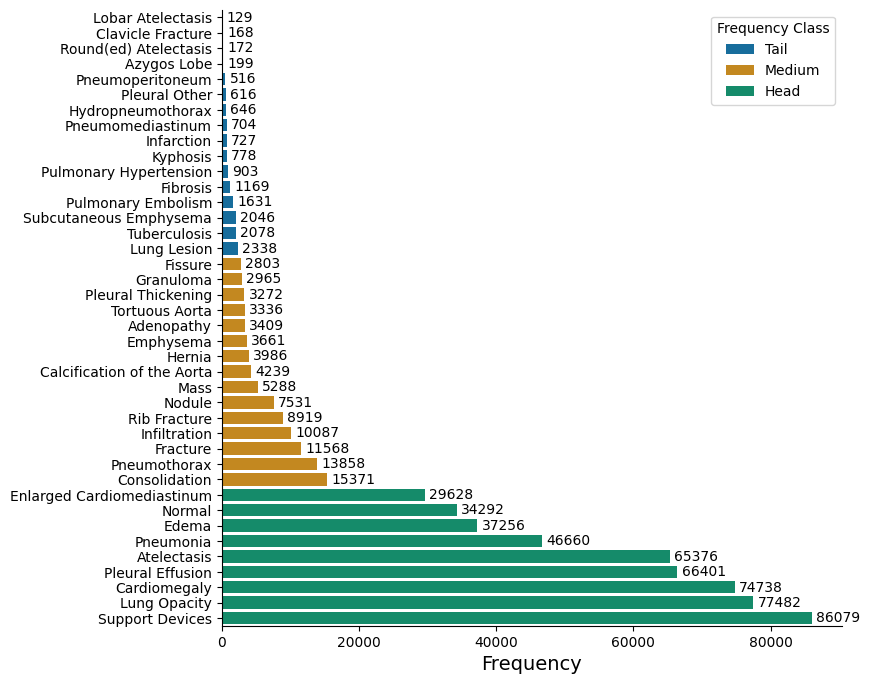

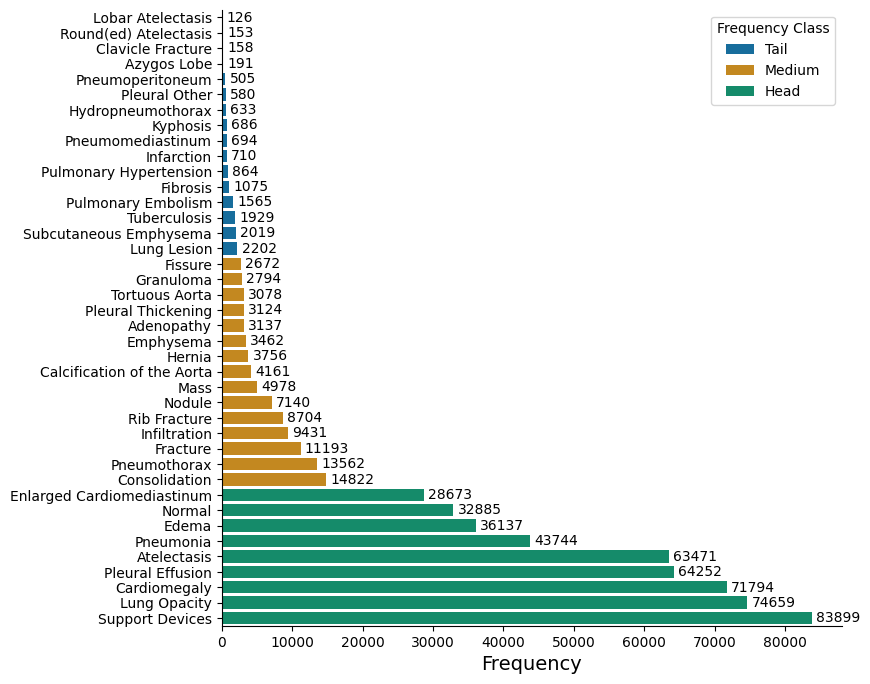

Reduction in tail classes with no views: 730 (4.93%)


In [11]:
def add_freq_class(label_counts: pd.DataFrame) -> pd.DataFrame:
    freq_class_bins = [0, 0.01 * total_rows, 0.1 * total_rows, 1.0 * total_rows]
    label_counts["freq_class"] = pd.cut(
        label_counts["Count"],
        bins=freq_class_bins,
        labels=["Tail", "Medium", "Head"],
        right=False,
        ordered=True,
    )

    return label_counts


no_views = train_df["ViewPosition"].isna()
print(
    f"Number of images with unknown view: {no_views.sum()} out of {total_rows} ({no_views.mean() * 100:.2f}%)"
)

label_counts = pd.DataFrame(train_df.iloc[:, 7:].sum(axis=0).sort_values())
label_counts.columns = ["Count"]
label_counts = add_freq_class(label_counts)
print(label_counts)
print(len(label_counts))
plot_label_counts(label_counts, "cxr24_label_counts.svg")

label_counts_no_views = pd.DataFrame(
    train_df[~no_views].iloc[:, 7:].sum(axis=0).sort_values()
)
label_counts_no_views.columns = ["Count"]
label_counts_no_views = add_freq_class(label_counts_no_views)
plot_label_counts(label_counts_no_views, "cxr24_label_counts_no_views.svg")

tail_classes_count = label_counts["Count"][label_counts["freq_class"] == "Tail"].sum()
tail_classes_no_views_count = label_counts_no_views["Count"][
    label_counts_no_views["freq_class"] == "Tail"
].sum()
diff = tail_classes_count - tail_classes_no_views_count
mean = diff / tail_classes_count
print(f"Reduction in tail classes with no views: {diff} ({mean:.2%})")


['Adenopathy' 'Atelectasis' 'Azygos Lobe' 'Calcification of the Aorta'
 'Cardiomegaly' 'Clavicle Fracture' 'Consolidation' 'Edema' 'Emphysema'
 'Enlarged Cardiomediastinum' 'Fibrosis' 'Fissure' 'Fracture' 'Granuloma'
 'Hernia' 'Hydropneumothorax' 'Infarction' 'Infiltration' 'Kyphosis'
 'Lobar Atelectasis' 'Lung Lesion' 'Lung Opacity' 'Mass' 'Nodule' 'Normal'
 'Pleural Effusion' 'Pleural Other' 'Pleural Thickening'
 'Pneumomediastinum' 'Pneumonia' 'Pneumoperitoneum' 'Pneumothorax'
 'Pulmonary Embolism' 'Pulmonary Hypertension' 'Rib Fracture'
 'Round(ed) Atelectasis' 'Subcutaneous Emphysema' 'Support Devices'
 'Tortuous Aorta' 'Tuberculosis'] 

['Lobar Atelectasis' 'Clavicle Fracture' 'Round(ed) Atelectasis'
 'Azygos Lobe' 'Pneumoperitoneum' 'Pleural Other' 'Hydropneumothorax'
 'Pneumomediastinum' 'Infarction' 'Kyphosis' 'Pulmonary Hypertension'
 'Fibrosis' 'Pulmonary Embolism' 'Subcutaneous Emphysema' 'Tuberculosis'
 'Lung Lesion'] 16 

['Fissure' 'Granuloma' 'Pleural Thickening' 'Tortu

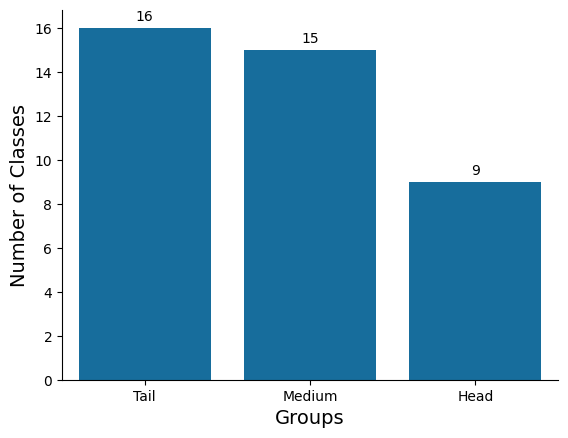

In [12]:
def get_label_indices(all_labels: np.ndarray, labels: np.ndarray) -> list:
    """Get indices of labels in the all_labels array."""
    return (
        np.array([np.where(all_labels == label) for label in labels]).flatten().tolist()
    )


labels = train_df.columns[7:].to_numpy()
print(labels, "\n")

tail_classes = label_counts[label_counts["freq_class"] == "Tail"].index.to_numpy()
medium_classes = label_counts[label_counts["freq_class"] == "Medium"].index.to_numpy()
head_classes = label_counts[label_counts["freq_class"] == "Head"].index.to_numpy()

print(tail_classes, len(tail_classes), "\n")
print(medium_classes, len(medium_classes), "\n")
print(head_classes, len(head_classes), "\n")

tail_classes_indices = get_label_indices(labels, tail_classes)
medium_classes_indices = get_label_indices(labels, medium_classes)
head_classes_indices = get_label_indices(labels, head_classes)

print(f"Tail classes indices: {tail_classes_indices}")
print(f"Medium classes indices: {medium_classes_indices}")
print(f"Head classes indices: {head_classes_indices}")

assert len(tail_classes) == len(tail_classes_indices)
assert len(medium_classes) == len(medium_classes_indices)
assert len(head_classes) == len(head_classes_indices)

ax = sns.barplot(
    x=["Tail", "Medium", "Head"],
    y=[len(tail_classes), len(medium_classes), len(head_classes)],
)
plt.xlabel("Groups")
plt.ylabel("Number of Classes")
for container in ax.containers:
    ax.bar_label(container, fmt="%d", label_type="edge", padding=3)

In [13]:
def display_image(path: Path | str):
    """Display an image from the given path."""
    img = cv2.imread(path)
    print(img.shape, img.min(), img.max())
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()

(3056, 2544, 3) 0 255


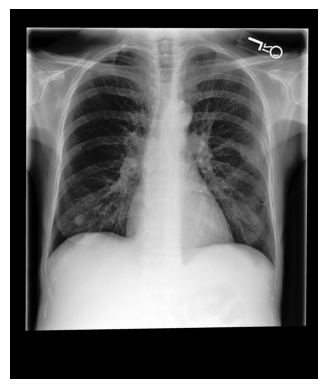

In [14]:
file_paths = train_df["fpath"]
display_image(IMGS_PATH / file_paths[0])

data/mimic-cxr-jpg-2.1.0/files/p14/p14306557/s57370900/79db9be0-1a40c0b4-78171b56-63d7969a-8aa661b0.jpg
(3056, 2544, 3) 0 255


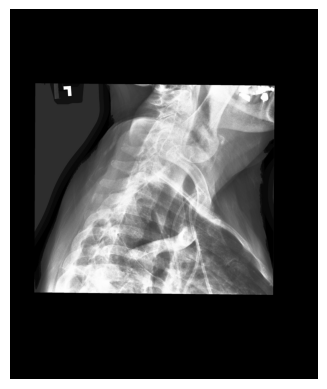

In [15]:
path = IMGS_PATH / train_df["fpath"][train_df["ViewPosition"] == "SWIMMERS"].values[0]
print(path)
display_image(path)

2
(3050, 2539, 3) 0 255


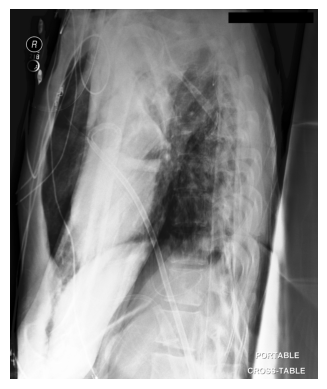

(3056, 2544, 3) 0 255


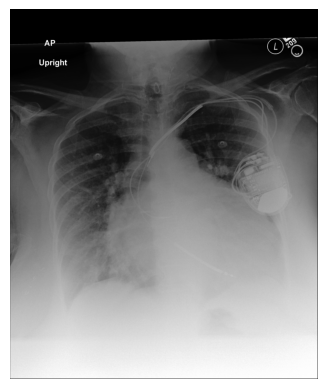

In [16]:
view = "XTABLE LATERAL"
img_paths = train_df["fpath"][train_df["ViewPosition"] == view].values
print(len(img_paths))
for img_path in img_paths:
    display_image(IMGS_PATH / img_path)

In [17]:
studies = train_df[["fpath", "View"]].groupby(train_df["study_id"])
print(len(studies))
for i, study in enumerate(studies):
    study_img = study[1]
    study_img_paths = IMGS_PATH / study_img["fpath"].values
    study_views = study_img["View"].values
    print(study_img_paths, study_views)
    if i > 5:
        break

155823
[PosixPath('data/mimic-cxr-jpg-2.1.0/files/p19/p19995127/s50000028/1ff9650f-4cb5af18-f6caef33-e53686b7-983cca76.jpg')
 PosixPath('data/mimic-cxr-jpg-2.1.0/files/p19/p19995127/s50000028/33708b7f-979612cb-46e1424c-318354bc-6f043189.jpg')] ['Lateral' 'Frontal']
[PosixPath('data/mimic-cxr-jpg-2.1.0/files/p19/p19309850/s50000125/dfa001f0-9c3d0a8c-b61096ea-e3b90c21-6228ddff.jpg')] ['Frontal']
[PosixPath('data/mimic-cxr-jpg-2.1.0/files/p19/p19999287/s50000173/c8bbb9ff-ecb81ef7-a1a6cecf-f535bd20-bd512ba0.jpg')] ['Frontal']
[PosixPath('data/mimic-cxr-jpg-2.1.0/files/p14/p14444780/s50000186/93bcf53f-7c91b330-3738f326-4d31769d-6cff6fe5.jpg')
 PosixPath('data/mimic-cxr-jpg-2.1.0/files/p14/p14444780/s50000186/c7dadf13-58bc3fd8-7e7f4ba4-9ac13218-43aae1b2.jpg')] ['Frontal' 'Lateral']
[PosixPath('data/mimic-cxr-jpg-2.1.0/files/p16/p16548129/s50000198/b66847d6-6848ea1f-58aa0c60-c38316ff-7e2171db.jpg')] ['Frontal']
[PosixPath('data/mimic-cxr-jpg-2.1.0/files/p13/p13658672/s50000511/5f930e4e-77b458

In [18]:
import timm
from pprint import pprint

pprint(timm.list_models("*convnext*fb*", pretrained=True))
timm.list_models("*convnextv2*", pretrained=True)

/sharedscratch/na200/hds-diss/.venv-local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['convnext_base.fb_in1k',
 'convnext_base.fb_in22k',
 'convnext_base.fb_in22k_ft_in1k',
 'convnext_base.fb_in22k_ft_in1k_384',
 'convnext_large.fb_in1k',
 'convnext_large.fb_in22k',
 'convnext_large.fb_in22k_ft_in1k',
 'convnext_large.fb_in22k_ft_in1k_384',
 'convnext_small.fb_in1k',
 'convnext_small.fb_in22k',
 'convnext_small.fb_in22k_ft_in1k',
 'convnext_small.fb_in22k_ft_in1k_384',
 'convnext_tiny.fb_in1k',
 'convnext_tiny.fb_in22k',
 'convnext_tiny.fb_in22k_ft_in1k',
 'convnext_tiny.fb_in22k_ft_in1k_384',
 'convnext_xlarge.fb_in22k',
 'convnext_xlarge.fb_in22k_ft_in1k',
 'convnext_xlarge.fb_in22k_ft_in1k_384']


['convnextv2_atto.fcmae',
 'convnextv2_atto.fcmae_ft_in1k',
 'convnextv2_base.fcmae',
 'convnextv2_base.fcmae_ft_in1k',
 'convnextv2_base.fcmae_ft_in22k_in1k',
 'convnextv2_base.fcmae_ft_in22k_in1k_384',
 'convnextv2_femto.fcmae',
 'convnextv2_femto.fcmae_ft_in1k',
 'convnextv2_huge.fcmae',
 'convnextv2_huge.fcmae_ft_in1k',
 'convnextv2_huge.fcmae_ft_in22k_in1k_384',
 'convnextv2_huge.fcmae_ft_in22k_in1k_512',
 'convnextv2_large.fcmae',
 'convnextv2_large.fcmae_ft_in1k',
 'convnextv2_large.fcmae_ft_in22k_in1k',
 'convnextv2_large.fcmae_ft_in22k_in1k_384',
 'convnextv2_nano.fcmae',
 'convnextv2_nano.fcmae_ft_in1k',
 'convnextv2_nano.fcmae_ft_in22k_in1k',
 'convnextv2_nano.fcmae_ft_in22k_in1k_384',
 'convnextv2_pico.fcmae',
 'convnextv2_pico.fcmae_ft_in1k',
 'convnextv2_tiny.fcmae',
 'convnextv2_tiny.fcmae_ft_in1k',
 'convnextv2_tiny.fcmae_ft_in22k_in1k',
 'convnextv2_tiny.fcmae_ft_in22k_in1k_384']

PhotometricInterpretation: MONOCHROME1
Image shape: (2336, 2080)
(2336, 2080) 0 4095
(2336, 2080) 0 255
Image shape after processing: (2336, 2080)


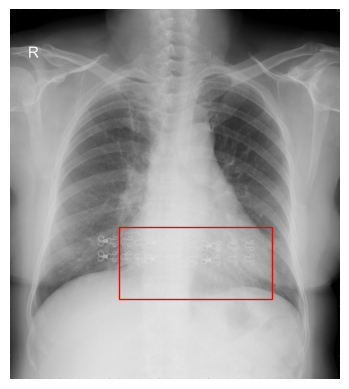

In [19]:
from pydicom.pixels.processing import apply_voi_lut, apply_modality_lut
import pydicom


def standardise_img(img: np.ndarray, photo_interpret: str) -> np.ndarray:
    """Standardize the image to have zero mean and unit variance."""
    img_std = ((img - img.min()) / img.max()) * 255.0
    if photo_interpret == "MONOCHROME1":
        img_std = 255.0 - img_std

    return img_std.astype(np.uint8)


# Load the DICOM file
ds = pydicom.dcmread("./data/vinbig-cxr/train/9a5094b2563a1ef3ff50dc5c7ff71345.dicom")
print(f"PhotometricInterpretation: {ds.PhotometricInterpretation}")
print(f"Image shape: {ds.pixel_array.shape}")

# Apply LUTs
img = apply_modality_lut(ds.pixel_array, ds)
img = apply_voi_lut(img, ds)
print(img.shape, img.min(), img.max())
img = standardise_img(img, ds.PhotometricInterpretation)
print(img.shape, img.min(), img.max())

print(f"Image shape after processing: {img.shape}")
# disease bbox coordinates
x_min, y_min, x_max, y_max = 691.0, 1375.0, 1653.0, 1831.0

plt.imshow(img, cmap="gray")
plt.gca().add_patch(
    plt.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        linewidth=1,
        edgecolor="red",
        facecolor="none",
    )
)
plt.axis("off")
plt.show()

In [20]:
img = cv2.imread("data/chexpert/CheXpert-v1.0/train/patient00002/study1/view1_frontal.jpg")
print(img.shape, img.min(), img.max())
img = cv2.imread("data/nih-cxr/images/00000003_004.png")
print(img.shape, img.min(), img.max())

(2320, 2828, 3) 0 255
(1024, 1024, 3) 0 255


In [ ]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("checkpoints/umlsbert/")
model = AutoModel.from_pretrained("checkpoints/umlsbert/")
# model("Lung opacity")
tokens = tokenizer("Lung opacity", return_tensors="pt")
model_output = model(**tokens)
model_output.pooler_output.shape

torch.Size([1, 768])